# <center> **DATA SCIENCE PROJECT** </center>
# <center>***Word Embedding***      </center>                                                                   
                                                                              
     DeepL                                                               Emma COVILI, Salomé PAPEREUX, Eloise ZAGHRINI

Importation of the libraries we are going to need.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.linear_model
from sklearn.manifold import TSNE
from sklearn.utils import extmath

import math
from statistics import mean
import time
import random

import torch
from scipy.spatial.distance import cosine
from torch import nn, mm
from torch.nn.functional import binary_cross_entropy
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD

from gensim.models import FastText, Word2Vec
from gensim.models import KeyedVectors

import re
import nltk
import plotly.graph_objects as go

## DATA IMPORTATION

In [ ]:
model_fr = KeyedVectors.load_word2vec_format('wiki.fr.vec')
model_en = KeyedVectors.load_word2vec_format('wiki.en.vec')
model_it = KeyedVectors.load_word2vec_format('wiki.it.vec')
model_el = KeyedVectors.load_word2vec_format('wiki.el.vec')
model_ch = KeyedVectors.load_word2vec_format('wiki.zh.vec')

Saving the model into files

In [ ]:
model_fr.save("word2vec_fr.model")
model_en.save("word2vec_en.model")
model_it.save("word2vec_it.model")
model_el.save("word2vec_el.model")
model_ch.save("word2vec_ch.model")

Saves importation

In [4]:
keyed_data_fr = KeyedVectors.load('word2vec_fr.model')
keyed_data_en = KeyedVectors.load('word2vec_en.model')
keyed_data_it = KeyedVectors.load('word2vec_it.model')
keyed_data_el = KeyedVectors.load('word2vec_el.model')
keyed_data_ch = KeyedVectors.load('word2vec_ch.model')

Converts word2Vec data in dictionary where
- key = word
- value = associated vector of size (300,)

We do this for each language

In [5]:
def keyedvectors_to_dico(data):
    dico = {}
    for key in data.index_to_key:
        dico[key] = data.get_vector(key)
    return dico

data_fr = keyedvectors_to_dico(keyed_data_fr)
data_en = keyedvectors_to_dico(keyed_data_en)
data_it = keyedvectors_to_dico(keyed_data_it)
data_el = keyedvectors_to_dico(keyed_data_el)
data_ch = keyedvectors_to_dico(keyed_data_ch)

Function that : 
- Importes the bilingual dictionnary file and turn it into a dataframe where 
    - the first column is the source language
    - the second column is the target language
    - lines are words
- Initialization of train and test set of bilingual dictionary in each language

In [76]:
def create_data(file_name, data_source, data_target):
    if 'fr' in file_name or 'ch' in file_name:
        words = pd.read_csv(file_name, sep=' ', header=None, na_filter=False)
    else : 
        words = pd.read_csv(file_name, sep='\t', header=None, na_filter=False)
    
    if 'it_' in file_name :
        words = words.rename(columns = {0: 'wordandtrad'})
        words = pd.DataFrame(words.wordandtrad.str.split('\t',1).tolist())
    
    #Check every word has an embedding
    for i in range(words.shape[0]):
        wsource, wtarget = words.loc[i]
        if len(data_source.get(wsource, ""))==0 or len(data_target.get(wtarget, ""))==0:
            words = words.drop(i, inplace=True)
        
    return words

#French-English bilingual dictionary
bilingual_train_fren = create_data('fr_en_train.txt', data_fr, data_en)
bilingual_test_fren = create_data('fr_en_test.txt', data_fr, data_en)
#English-French bilingual dictionary
bilingual_train_enfr = create_data('en_fr_train.txt', data_en, data_fr)
bilingual_test_enfr = create_data('en_fr_test.txt', data_en, data_fr)

#French-Italian bilingual dictionary
bilingual_train_frit = create_data('fr_it_train.txt', data_fr, data_it)
bilingual_test_frit = create_data('fr_it_test.txt', data_fr, data_it)
#Italian-French bilingual dictionary
bilingual_train_itfr = create_data('it_fr_train.txt', data_it, data_fr)
bilingual_test_itfr = create_data('it_fr_test.txt', data_it, data_fr)

#English-Greek bilingual dictionary
bilingual_train_enel = create_data('en_el_train.txt', data_en, data_el)
bilingual_test_enel = create_data('en_el_test.txt', data_en, data_el)
#Greek-English bilingual dictionary
bilingual_train_elen = create_data('el_en_train.txt', data_el, data_en)
bilingual_test_elen = create_data('el_en_test.txt', data_el, data_en)

#English-Chinese bilingual dictionary
bilingual_train_ench = create_data('en_ch_train.txt', data_en, data_ch)
bilingual_test_ench = create_data('en_ch_test.txt', data_en, data_ch)

Here, we create the train and test set vector representation of words in each language

The function : 
- Creates two lists of vectors (in source and target language) indexed the same way as the bilingual dictionnary : the same index gives the vector of the word in fr and in en, according to which list your looking at.

In [7]:
def from_word_to_vect(words, data_source, data_target):
    
    vect_source = np.zeros((len(words),300))
    vect_target = np.zeros((len(words),300))
    
    for i in range (len(words)):
        wsource, wtarget = words.loc[i]
        vect_source[i] = data_source.get(wsource)
        vect_target[i] = data_target.get(wtarget)

    return vect_source, vect_target

#French-English train and test set
fr_train_fren, en_train_fren = from_word_to_vect(bilingual_train_fren, data_fr, data_en)
fr_test_fren, en_test_fren = from_word_to_vect(bilingual_test_fren, data_fr, data_en)
#English-French train and test set
fr_train_enfr, en_train_enfr = from_word_to_vect(bilingual_train_enfr, data_en, data_fr)
fr_test_enfr, en_test_enfr = from_word_to_vect(bilingual_test_enfr, data_en, data_fr)

#French-Italian train and test set
fr_train_frit, it_train_frit = from_word_to_vect(bilingual_train_frit, data_fr, data_it)
fr_test_frit, it_test_frit = from_word_to_vect(bilingual_test_frit, data_fr, data_it)
#Italien-French train and test set
it_train_itfr, fr_train_itfr = from_word_to_vect(bilingual_train_itfr, data_it, data_fr)
it_test_itfr, fr_test_itfr = from_word_to_vect(bilingual_test_itfr, data_it, data_fr)

#English-Greek train and test set
en_train_enel, el_train_enel = from_word_to_vect(bilingual_train_enel, data_en, data_el)
en_test_enel, el_test_enel = from_word_to_vect(bilingual_test_enel, data_en, data_el)
#Greek-English train and test set
el_train_elen, en_train_elen = from_word_to_vect(bilingual_train_elen, data_el, data_en)
el_test_elen, en_test_elen = from_word_to_vect(bilingual_test_elen, data_el, data_en)

#English-Chinese train and test set
en_train_ench, ch_train_ench = from_word_to_vect(bilingual_train_ench, data_en, data_ch)
en_test_ench, ch_test_ench = from_word_to_vect(bilingual_test_ench, data_en, data_ch)

## I - SUPERVISED LEARNING

> ### 1) Linear regression to find W

Suppose we are given a set of word pairs and their associated vector representations $ \{x_i, z_i\}^{n}_{i=1} $, where $x_i \in {R}^{d_1}$ is the distributed representation of word $i$ in the source language, and $z_i \in R^{d_2}$ is the vector representation of its translation.
It is our goal to find a transformation matrix $W$ such that $Wx_i$ approximates $z_i$. In practice, $W$ can
be learned by the following optimization problem $$ \min_W \sum_{i=1}^{n} \|Wx_i - z_i\|^2$$

which we solve with stochastic gradient descent.


At the prediction time, for any given new word
and its continuous vector representation $x$, we can
map it to the other language space by computing $z =
W x$. Then we find the word whose representation
is closest to $z$ in the target language space, using
**cosine similarity** as the distance metric.
Despite its simplicity, this linear transformation
method worked well in our experiments, better than
nearest neighbor and as well as neural network classifiers. The following experiments will demonstrate
its effectiveness.

In [8]:
class Initializer:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.W = np.random.random(size=(self.X.shape[1],self.X.shape[1]))
        self.nearest_distance = None
        self.one_nearest_distance = None
        self.all_nearest_words = None
        self.one_nearest_word = []
        self.all_nearest_words_hub = []
        self.history = {"train" : [], "test" : []}
        self.accuracies = [0,0,0,0,0,0,0]
        self.accuracies_hub = [0,0,0,0,0,0,0]
        
    def RMSE(self, X, Y):
        return np.sqrt(np.square(X @ self.W - Y).mean())
    
    
    #K BEST PREDICTIONS WITH NORM METRIC
    
    def accuracy(self, X_test, bilingual_test, hub=False):        
        if hub:
            nearest_words = self.all_nearest_words_hub
            accuracies = self.accuracies_hub
        else : 
            nearest_words = self.all_nearest_words
            accuracies = self.accuracies
            
        n, _ = X_test.shape
        k = len(accuracies)
        
        for i in range(n):
            accu = 0
            source_word , true_word = bilingual_test.loc[i]
            
            for ii in range(0, k):
                predicted_words = nearest_words[i][0:ii+1]
                if true_word in predicted_words:
                     accuracies[ii]+=1
        
        for idx in range(k):
            accuracies[idx] /= n
                
        return accuracies
    
    def predict(self, X_test, Y_test, bilingual_test):
        n, _ = X_test.shape
        p, _ = Y_test.shape 
        self.nearest_distance = np.ones((n,7)) * math.inf
        
        self.all_nearest_words = []
        #Initialization of nearest words
        for i in range (n):
            words = []
            for j in range (len(self.accuracies)):
                words.append(" ")
            self.all_nearest_words.append(words)
        

        for i in range (n):
            if i%500==0:
                print("State of predict: ", i, "/", n)
            Y_pred = X_test[i] @ self.W
            
            for j in range (p):
                distance = np.linalg.norm(Y_pred-Y_test[j])

                if distance<max(self.nearest_distance[i]): 
                    index_update = np.argmax(self.nearest_distance[i])
                    self.nearest_distance[i, index_update] = distance
                    _, word_target = bilingual_test.loc[j]
                    self.all_nearest_words[i][index_update] = word_target
                    
            #Sort the words by ascending distances
            index_sorted = np.argsort(self.nearest_distance[i])
            self.all_nearest_words[i] = [self.all_nearest_words[i][x] for x in index_sorted]
            self.nearest_distance[i] =  [self.nearest_distance[i][x] for x in index_sorted]
        
        t2=time.time()    
        return self.all_nearest_words
    
    
    #ONE BEST PREDICTION WITH NORM METRIC
    
    def one_predict(self, X_test, Y_test, bilingual_test):
        t = time.time()
        n, m = X_test.shape
        p, q = Y_test.shape
        self.one_nearest_distance = np.ones((n,1)) * math.inf
        self.one_nearest_word = []


        for i in range (n):
            Y_pred = X_test[i] @ self.W
            
            for j in range (p):
                distance = np.linalg.norm(Y_pred-Y_test[j])

                if distance<self.one_nearest_distance[i]: 
                    self.one_nearest_distance[i] = distance
                    _, nearest_word = bilingual_test.loc[j]
                    
            self.one_nearest_word.append(nearest_word)
        return self.one_nearest_word
    
    def one_accuracy(self, X_test, bilingual_test):
        n, _ = X_test.shape
        accu = 0

        for i in range(n):
            _ , true_word = bilingual_test.loc[i]
            predicted_word = self.one_nearest_word[i]
            
            if true_word == predicted_word:
                 accu+=1
                
        return accu/n
    
    
    #K BESTS PREDICTIONS WITH COSINE METRIC
   
    def predict_cosine(self, X_test, Y_test, bilingual_test):
        n, _ = X_test.shape
        self.all_nearest_words = []
        
        #Initialization of nearest words
        for i in range (n):
            words = []
            for j in range (len(self.accuracies)):
                words.append("")
            self.all_nearest_words.append(words)
                
        
        distances = cosine_similarity(X_test @ self.W , Y_test)
        idx_best = np.argmax(distances, axis=1) 
        
        for i in range (len(self.accuracies)):
            idx_best = np.argmax(distances, axis=1) 
            
            for j, idx in zip(np.arange(n), idx_best):
                _, nearest_word = bilingual_test.loc[idx]
                self.all_nearest_words[j][i] = nearest_word
                distances[j][idx] = 0
            
        return self.all_nearest_words
    
    
    #ONE BEST PREDICTION WITH COSINE METRIC
    
    def one_predict_cosine(self, X_test, Y_test, bilingual_test):
        n, _ = X_test.shape
        self.one_nearest_word = []
        
        distances = cosine_similarity(X_test @ self.W , Y_test)
        idx_best = np.argmax(distances, axis=1) 
            
        for idx in idx_best:
            _, nearest_word = bilingual_test.loc[idx]
            self.one_nearest_word.append(nearest_word)
            
        return self.one_nearest_word
     
    
    #CONSIDER HUBNESS ISSUE
    def hubness_predict(self, X_test, Y_test, bilingual_test):
        n, _ = X_test.shape
        
        #Initialization of nearest words
        for i in range (n):
            words = []
            for j in range (len(self.accuracies)):
                words.append("")
            self.all_nearest_words_hub.append(words)
        
        distances = cosine_similarity(X_test @ self.W , Y_test)
        distances_copy = np.copy(distances)
        idx_best = np.argmax(distances, axis=1) 
        
        for i in range (len(self.accuracies)):
            idx_best = np.argmax(distances, axis=1)
            
            for j, idx in zip(np.arange(n), idx_best):
                stop = False
                nb_iter = 0
                idx_iter = idx
                
                #Check if the source word is in the NN of the temporary nearest_word 
                while not stop and nb_iter<5: 
                    NN = []
                    _, nearest_word = bilingual_test.loc[idx_iter]
                    for _ in range(7):
                        idx_best_inverse = np.argmax(distances[:,idx_iter]) 
                        nearest_word_inverse, _ = bilingual_test.loc[idx_best_inverse]
                        NN.append(nearest_word_inverse)
                        distances[idx_best_inverse, idx_iter] = 0 
                    distances[idx_best_inverse] = distances_copy[idx_best_inverse] 

                    true_word, true_target_word =  bilingual_test.loc[j]
                    if true_word in NN :
                        stop = True
                    else : 
                        distances[j][idx_iter] = 0
                        idx_iter =  np.argmax(distances[j])
                        nb_iter += 1          
                        
                 #The true word and predicted word are both in the neighbordhood of the other one
                idx = idx_iter
                _, nearest_word = bilingual_test.loc[idx]
                self.all_nearest_words_hub[j][i] = nearest_word
                distances[j][idx] = 0
            
        return self.all_nearest_words_hub
    
    def print_nearest_words(self, X_test, bilingual_test, hub=False):
        n, _ = X_test.shape
        if hub:
            nearest_words = self.all_nearest_words_hub
        else : 
            nearest_words = self.all_nearest_words
            
        for i in range(n):
            _, target_word = bilingual_test.loc[i]
            predicted_words = nearest_words[i]
            print(target_word, " : ", predicted_words )

### ORDINARY LEAST SQUARED

In [9]:
class LinearTransform(Initializer):
    def __init__(self, X, Y):
        super().__init__(X,Y)

    def fit(self, lambda_reg=2):
        _, m = self.X.shape
        self.W = np.linalg.inv(self.X.T @ self.X + lambda_reg * np.eye(m)) @ (self.X.T @ self.Y)
        return self.W    

>>#### a - French to English

In [10]:
model_ols_fren = LinearTransform(fr_train_fren, en_train_fren)
model_ols_fren.fit()
model_ols_fren.predict_cosine(fr_test_fren, en_test_fren, bilingual_test_fren)
print("Accuracy on Test Set with Cosine Metric: ", model_ols_fren.accuracy(fr_test_fren, bilingual_test_fren)[0])
print("RMSE train : ", model_ols_fren.RMSE(fr_train_fren, en_train_fren))
print("RMSE test : ", model_ols_fren.RMSE(fr_test_fren, en_test_fren))

Accuracy on Test Set with Cosine Metric:  0.5661827497865073
RMSE train :  0.18127241859727575
RMSE test :  0.1946317804204162


In [11]:
#Solving hubness issue
model_ols_fren.hubness_predict(fr_test_fren, en_test_fren, bilingual_test_fren)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_fren.accuracy(fr_test_fren, bilingual_test_fren, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.4854824935952178


>>#### b - English to French

In [12]:
model_ols_enfr = LinearTransform(en_train_enfr, fr_train_enfr)
model_ols_enfr.fit()
model_ols_enfr.predict_cosine(en_test_enfr, fr_test_enfr, bilingual_test_enfr)
print("Accuracy on Test Set : ", model_ols_enfr.accuracy(en_test_enfr, bilingual_test_enfr)[0])
print("RMSE train : ", model_ols_enfr.RMSE(en_train_enfr, fr_train_enfr))
print("RMSE test : ", model_ols_enfr.RMSE(en_test_enfr, fr_test_enfr))

Accuracy on Test Set :  0.4240570846075433
RMSE train :  0.17676560872299793
RMSE test :  0.1890783426937072


In [13]:
model_ols_enfr.hubness_predict(en_test_enfr, fr_test_enfr, bilingual_test_enfr)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_enfr.accuracy(en_test_enfr, bilingual_test_enfr, hub=True))

Accuracy Hubness on Test Set with Cosine Metric:  [0.5722052327556915, 0.6258919469928644, 0.6632687733605165, 0.6826367652055726, 0.7003058103975535, 0.7162759089364594, 0.72782874617737]


In [ ]:
"""
def hubness_word_plot(X_test, Y_test, model, bilingual_test)
    distances = cosine_similarity(X_test @ model.W , Y_test)
    idx_hubword = bilingual_test[bilingual_test[1]=="problématique"].index.tolist()[0]
    NN = []
    for _ in range (10):
        idx_max = plt.argmax(distances[:,idx_hubword])
        distances[idx_max, idx_hubword] = 0
        NN.append(idx_max)
    tsne_plot(NN, fr_test_frit, it_test_frit, W, data_fr, data_it, bilingual_test_frit, "Linear Transform")

        
hubness_word_plot(en_test_enfr, model_ols_enfr, bilingual_test_fren)   """     


>>#### c - French to Italian 

In [14]:
model_ols_frit = LinearTransform(fr_train_frit, it_train_frit)
model_ols_frit.fit()
model_ols_frit.predict_cosine(fr_test_frit, it_test_frit, bilingual_test_frit)
print("Accuracy on Test Set : ", model_ols_frit.accuracy(fr_test_frit, bilingual_test_frit)[0])
print("RMSE train : ", model_ols_frit.RMSE(fr_train_frit, it_train_frit))
print("RMSE test : ", model_ols_frit.RMSE(fr_test_frit, it_test_frit))

Accuracy on Test Set :  0.8888888888888888
RMSE train :  0.16538406827604063
RMSE test :  0.18753676399514085


In [15]:
#Solving hubness issue
model_ols_frit.hubness_predict(fr_test_frit, it_test_frit, bilingual_test_frit)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_frit.accuracy(fr_test_frit, bilingual_test_frit, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.826797385620915


>>#### d - Italian to French

In [16]:
model_ols_itfr = LinearTransform(it_train_itfr, fr_train_itfr)
model_ols_itfr.fit()
model_ols_itfr.predict_cosine(it_test_itfr, fr_test_itfr, bilingual_test_itfr)
print("Accuracy on Test Set : ", model_ols_itfr.accuracy(it_test_itfr, bilingual_test_itfr)[0])
print("RMSE train : ", model_ols_itfr.RMSE(it_train_itfr, fr_train_itfr))
print("RMSE test : ", model_ols_itfr.RMSE(it_test_itfr, fr_test_itfr))

Accuracy on Test Set :  0.7813378302417088
RMSE train :  0.1729499475827299
RMSE test :  0.19195277863505783


In [17]:
#Solving hubness issue
model_ols_itfr.hubness_predict(it_test_itfr, fr_test_itfr, bilingual_test_itfr)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_itfr.accuracy(it_test_itfr, bilingual_test_itfr, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.7200674536256324


>>#### e - English to Greek

In [18]:
model_ols_enel = LinearTransform(en_train_enel, el_train_enel)
model_ols_enel.fit()
model_ols_enel.predict_cosine(en_test_enel, el_test_enel, bilingual_test_enel)
print("Accuracy on Test Set : ", model_ols_enel.accuracy(en_test_enel, bilingual_test_enel)[0])
print("RMSE train : ", model_ols_enel.RMSE(en_train_enel, el_train_enel))
print("RMSE test : ", model_ols_enel.RMSE(en_test_enel, el_test_enel))

Accuracy on Test Set :  0.4003960396039604
RMSE train :  0.22365287828057606
RMSE test :  0.23122369570844864


In [19]:
#Solving hubness issue
model_ols_enel.hubness_predict(en_test_enel, el_test_enel, bilingual_test_enel)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_enel.accuracy(en_test_enel, bilingual_test_enel, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.35366336633663364


>>#### f - Greek to English

In [20]:
model_ols_elen = LinearTransform(el_train_elen, en_train_elen)
model_ols_elen.fit()
model_ols_elen.predict_cosine(el_test_elen, en_test_elen, bilingual_test_elen)
print("Accuracy on Test Set : ", model_ols_elen.accuracy(el_test_elen, bilingual_test_elen)[0])
print("RMSE train : ", model_ols_elen.RMSE(el_train_elen, en_train_elen))
print("RMSE test : ", model_ols_elen.RMSE(el_test_elen, en_test_elen))

Accuracy on Test Set :  0.517607332368548
RMSE train :  0.1814644022973119
RMSE test :  0.20283158047637584


In [21]:
#Solving hubness issue
model_ols_elen.hubness_predict(el_test_elen, en_test_elen, bilingual_test_elen)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_elen.accuracy(el_test_elen, bilingual_test_elen, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.44187168355041


>>#### g - English to Chinese

In [22]:
model_ols_ench = LinearTransform(en_train_ench, ch_train_ench)
model_ols_ench.fit()
model_ols_ench.predict_cosine(en_test_ench, ch_test_ench, bilingual_test_ench)
print("Accuracy on Test Set : ", model_ols_ench.accuracy(en_test_ench, bilingual_test_ench)[0])
print("RMSE train : ", model_ols_ench.RMSE(en_train_ench, ch_train_ench))
print("RMSE test : ", model_ols_ench.RMSE(en_test_ench, ch_test_ench))

Accuracy on Test Set :  0.2304932735426009
RMSE train :  0.20092490616770117
RMSE test :  0.21735127498179388


In [23]:
#Solving hubness issue
model_ols_ench.hubness_predict(en_test_ench, ch_test_ench, bilingual_test_ench)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ols_ench.accuracy(en_test_ench, bilingual_test_ench, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.1937219730941704


>>#### g - French to French

In [62]:
bilingual_train_frfr = create_data('fr_en_train.txt', data_fr, data_fr)
bilingual_test_frfr = create_data('fr_en_test.txt', data_fr, data_fr)
bilingual_train_frfr.iloc[:,1] = bilingual_train_frfr.iloc[:,0] 
bilingual_test_frfr.iloc[:,1] = bilingual_test_frfr.iloc[:,0] 

fr_train_source, fr_train_target = from_word_to_vect(bilingual_train_frfr, data_fr, data_fr)
fr_test_source, fr_test_target = from_word_to_vect(bilingual_test_frfr, data_fr, data_fr)

In [63]:
model_ols_frfr = LinearTransform(fr_train_source, fr_train_target)
model_ols_frfr.fit()
model_ols_frfr.predict_cosine(fr_test_source, fr_test_target, bilingual_test_frfr)
print("Accuracy on Test Set : ", model_ols_frfr.accuracy(fr_test_source, bilingual_test_frfr)[0])
print("RMSE train : ", model_ols_frfr.RMSE(fr_train_source, fr_train_target))
print("RMSE test : ", model_ols_frfr.RMSE(fr_test_source, fr_test_target))

Accuracy on Test Set :  1.0
RMSE train :  0.0012210070745023761
RMSE test :  0.001366221849285524


> ### 2) Orthogonal transform

We solve this problem by using the norm distance in the transform learning :

$$ \min_W \sum_i ||Wx_i - z_i||^2 $$

To solve the problem, we first consider the case where the dimensions of the source and target vector spaces are the same. In this case, the normalization constraint on word vectors can be satisfied by constraining $W$ as an orthogonal matrix, which turns the unconstrained problem (4) to a constrained
optimization problem. A general solver such as SQP can be used to solve the problem. However, we seek a simple approximation in this work. Firstly, solve
(4) by gradient descendant without considering any constraint. A simple calculation shows that the gradient is as follows:

$$ \nabla W = 2X^T (XW - Z) $$

and the update rule is simply given by:

$$ W = W + \alpha\nabla W $$

where $α$ is the learning rate. After the update, W is
orthogonalized by solving the following constrained quadratic problem:

$$ \min_\bar{W} \|W − \bar{W}\|~~s.t.~~\bar{W}^T \bar{W} = Id $$

One can show that this problem can be solved by taking the singular value decomposition (SVD) of $W$ and replacing the singular values to ones.

In [24]:
class OrthogonalTransform(Initializer):

    def __init__(self, X, Y, epochs=150):
        super().__init__(X,Y)
        self.epochs = epochs

    def fit(self, X_test, Y_test, lr=0.0002):
        n, m = self.X.shape

        for _ in range (self.epochs):
            self.W = self.W - (2 *lr * self.X.T @ (self.X @ self.W - self.Y))
            Q, E, P = np.linalg.svd(self.W, full_matrices=True)
            self.W = Q @ np.eye(m) @ P
            
            self.history["train"].append(self.RMSE(self.X, self.Y))
            self.history["test"].append(self.RMSE(X_test, Y_test))
        return self.W
    
    def plot_history(self):
        plt.plot(np.arange(self.epochs), self.history["train"], label="Train Set")
        plt.plot(np.arange(self.epochs), self.history["test"], label="Test Set")
        plt.title("RMSE of Orthogonal Transform according to Time")
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()

>> #### a - French to English

Accuracy on Test Set :  0.5747224594363791


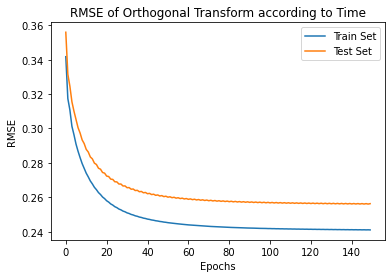

In [25]:
model_ortho_fren = OrthogonalTransform(fr_train_fren, en_train_fren)
model_ortho_fren.fit(fr_test_fren, en_test_fren)
model_ortho_fren.predict_cosine(fr_test_fren, en_test_fren, bilingual_test_fren)
print("Accuracy on Test Set : ", model_ortho_fren.accuracy(fr_test_fren, bilingual_test_fren)[0])
model_ortho_fren.plot_history()

In [26]:
#Solving hubness issue
model_ortho_fren.hubness_predict(fr_test_fren, en_test_fren, bilingual_test_fren)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_fren.accuracy(fr_test_fren, bilingual_test_fren, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.47865072587532026


#### Overview of supervised transformations with all words in the test set

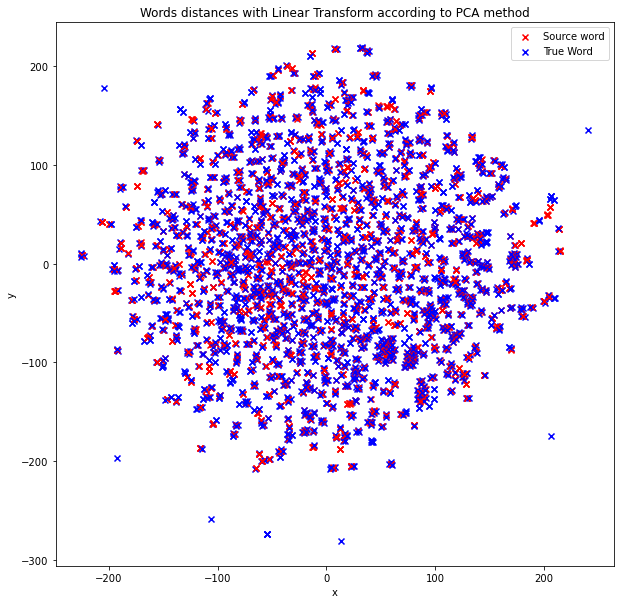

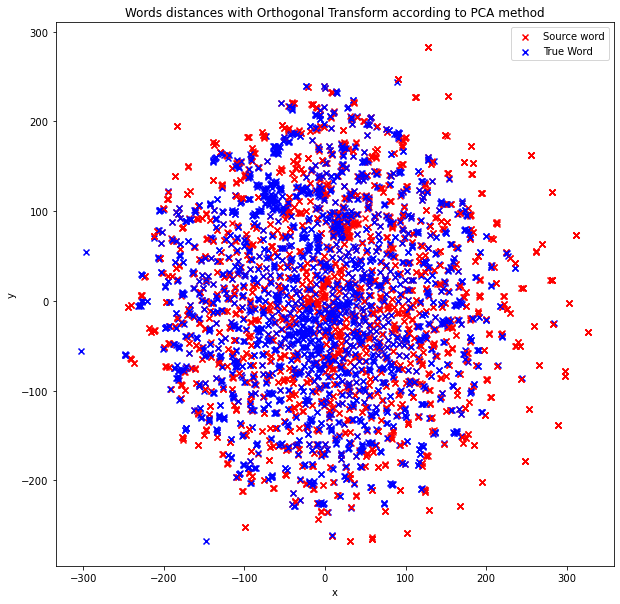

In [74]:
idx_to_plot = [i for i in range(len(fr_test_fren))]
W = model_ols_fren.W
tsne_plot(idx_to_plot, fr_test_fren, en_test_fren, W, data_fr, data_en, bilingual_test_fren, "Linear Transform", allpoints=True)

W = model_ortho_fren.W
tsne_plot(idx_to_plot, fr_test_fren, en_test_fren, W, data_fr, data_en, bilingual_test_fren, "Orthogonal Transform", allpoints=True)

>> #### b - English to French

Accuracy on Test Set :  0.43017329255861364


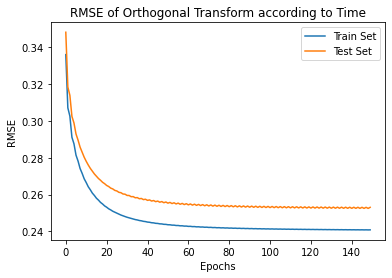

In [27]:
model_ortho_enfr = OrthogonalTransform(en_train_enfr, fr_train_enfr)
model_ortho_enfr.fit(en_test_enfr, fr_test_enfr)
model_ortho_enfr.predict_cosine(en_test_enfr, fr_test_enfr, bilingual_test_enfr)
print("Accuracy on Test Set : ", model_ortho_enfr.accuracy(en_test_enfr, bilingual_test_enfr)[0])
model_ortho_enfr.plot_history()

In [28]:
#Solving hubness issue
model_ortho_enfr.hubness_predict(en_test_enfr, fr_test_enfr, bilingual_test_enfr)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_enfr.accuracy(en_test_enfr, bilingual_test_enfr, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.5800203873598369


>> #### c - French to Italian

Accuracy on Test Set :  [0.9013071895424837, 0.9424836601307189, 0.9503267973856209, 0.9555555555555556, 0.9594771241830066, 0.965359477124183, 0.9666666666666667]


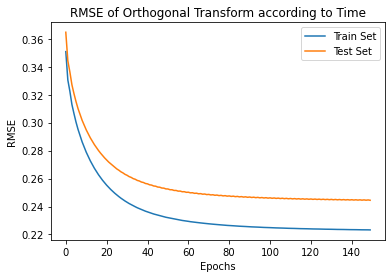

In [29]:
model_ortho_frit = OrthogonalTransform(fr_train_frit, it_train_frit)
model_ortho_frit.fit(fr_test_frit, it_test_frit)
model_ortho_frit.predict_cosine(fr_test_frit, it_test_frit, bilingual_test_frit)
print("Accuracy on Test Set : ", model_ortho_frit.accuracy(fr_test_frit, bilingual_test_frit))
model_ortho_frit.plot_history()

In [30]:
#Solving hubness issue
model_ortho_frit.hubness_predict(fr_test_frit, it_test_frit, bilingual_test_frit)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_frit.accuracy(fr_test_frit, bilingual_test_frit, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.8411764705882353


>> #### d - Italian to French

Accuracy on Test Set :  [0.7886453063518831, 0.9027543563799888, 0.9280494659921305, 0.9454749859471613, 0.9527824620573356, 0.9550309162450815, 0.955593029792018]


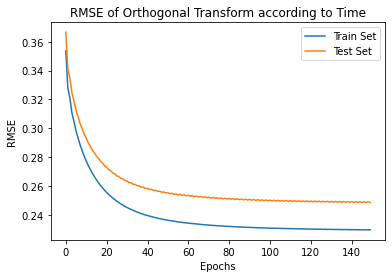

In [31]:
model_ortho_itfr = OrthogonalTransform(it_train_itfr, fr_train_itfr)
model_ortho_itfr.fit(it_test_itfr, fr_test_itfr)
model_ortho_itfr.predict_cosine(it_test_itfr, fr_test_itfr, bilingual_test_itfr)
print("Accuracy on Test Set : ", model_ortho_itfr.accuracy(it_test_itfr, bilingual_test_itfr))
model_ortho_itfr.plot_history()

In [32]:
#Solving hubness issue
model_ortho_itfr.hubness_predict(it_test_itfr, fr_test_itfr, bilingual_test_itfr)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_itfr.accuracy(it_test_itfr, bilingual_test_itfr, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.7116357504215851


>> #### e - English to Greek 

Accuracy on Test Set :  0.4198019801980198


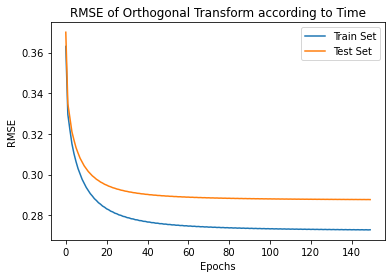

In [33]:
model_ortho_enel = OrthogonalTransform(en_train_enel, el_train_enel)
model_ortho_enel.fit(en_test_enel, el_test_enel)
model_ortho_enel.predict_cosine(en_test_enel, el_test_enel, bilingual_test_enel)
print("Accuracy on Test Set : ", model_ortho_enel.accuracy(en_test_enel, bilingual_test_enel)[0])
model_ortho_enel.plot_history()

In [34]:
#Solving hubness issue
model_ortho_enel.hubness_predict(en_test_enel, el_test_enel, bilingual_test_enel)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_enel.accuracy(en_test_enel, bilingual_test_enel, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.35445544554455444


>> #### f - Greek to English

Accuracy on Test Set :  0.5412445730824892


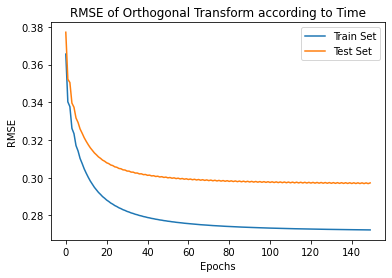

In [35]:
model_ortho_elen = OrthogonalTransform(el_train_elen, en_train_elen)
model_ortho_elen.fit(el_test_elen, en_test_elen)
model_ortho_elen.predict_cosine(el_test_elen, en_test_elen, bilingual_test_elen)
print("Accuracy on Test Set : ", model_ortho_elen.accuracy(el_test_elen, bilingual_test_elen)[0])
model_ortho_elen.plot_history()

In [36]:
#Solving hubness issue
model_ortho_elen.hubness_predict(el_test_elen, en_test_elen, bilingual_test_elen)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_elen.accuracy(el_test_elen, bilingual_test_elen, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.4442836468885673


>> #### g - English to Chinese

Accuracy on Test Set :  0.43811659192825114


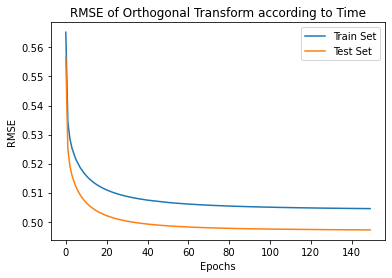

In [37]:
model_ortho_ench = OrthogonalTransform(en_train_ench, ch_train_ench)
model_ortho_ench.fit(en_test_ench, ch_test_ench)
model_ortho_ench.predict_cosine(en_test_ench, ch_test_ench, bilingual_test_ench)
print("Accuracy on Test Set : ", model_ortho_ench.accuracy(en_test_ench, bilingual_test_ench)[0])
model_ortho_ench.plot_history()

In [38]:
#Solving hubness issue
model_ortho_ench.hubness_predict(en_test_ench, ch_test_ench, bilingual_test_ench)
print("Accuracy Hubness on Test Set with Cosine Metric: ", 
      model_ortho_ench.accuracy(en_test_ench, bilingual_test_ench, hub=True)[0])

Accuracy Hubness on Test Set with Cosine Metric:  0.295067264573991


> ### 3) Simple procruste

Same results as orthogonal transform 

In [39]:
class Procruste(Initializer):

    def __init__(self, X, Y):
        super().__init__(X,Y)

    def fit(self, X_test, Y_test):
        n, m = self.X.shape
        Q, E, P = np.linalg.svd(self.X.T @ self.Y, full_matrices=True)
        self.W = Q @ np.eye(m) @ P
        return self.W

In [40]:
procruste_fren = Procruste(fr_train_fren, en_train_fren)
procruste_fren.fit(fr_test_fren, en_test_fren)
procruste_fren.predict_cosine(fr_test_fren, en_test_fren, bilingual_test_fren)
print("Accuracy on Test Set : ", procruste_fren.accuracy(fr_test_fren, bilingual_test_fren)[0])

Accuracy on Test Set :  0.5738684884713919


## PLOTS

In [70]:
def tsne_plot(idx_to_plot, X_test, Y_test, W, data_source, data_target, bilingual_words, method, allpoints=False):
    vectors = []
    words = []
    
    for idx in idx_to_plot:
        #Source words
        wsource,  wtarget  = bilingual_words.loc[idx] 
        words.append(wsource)
        vectors.append(data_source[wsource] @ W)
        #True word 
        words.append(wtarget)
        vectors.append(data_target[wtarget])   
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        #Source word 
        if i%2==0 : 
            if i==0 : 
                plt.scatter(x[i],y[i], c = 'red', label="Source word", marker='x')
            else : 
                plt.scatter(x[i],y[i], c = 'red', marker='x')
            if not allpoints:
                plt.annotate(words[i], xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', weight='bold',  fontsize=13, color='red')
        
        #True word
        else: 
            if i == 1:
                plt.scatter(x[i],y[i], c = '#0000FF', label="True Word", marker='x')
            else : 
                plt.scatter(x[i],y[i], c = '#0000FF', marker='x')
            if not allpoints:
                plt.annotate(words[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points',
                         ha='right', va='bottom', weight='bold',  fontsize=13, color='#0000FF')   
            
    title = "Words distances with " + method + " according to PCA method"        
    plt.title(title) 
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

>> #### a - Comparison between Linear and Orthogonal Transform French and English

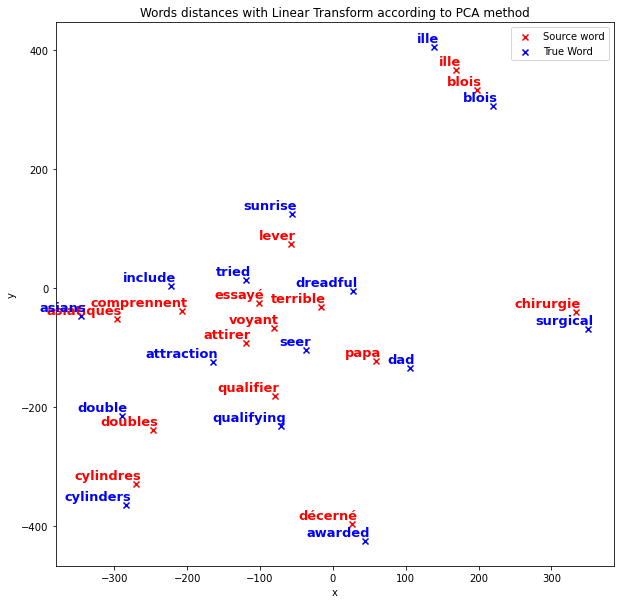

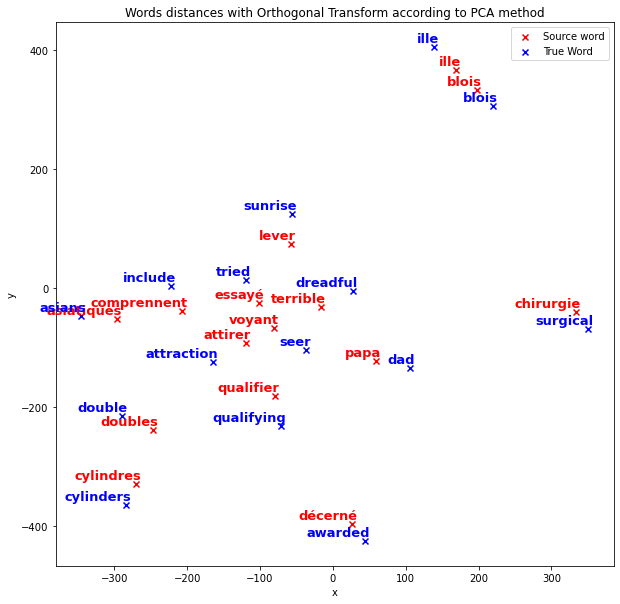

In [42]:
idx_to_plot = random.sample(range(0, len(en_test_fren)), 15)
W = model_ols_fren.W
tsne_plot(idx_to_plot, fr_test_enfr, en_test_enfr, W, data_fr, data_en, bilingual_test_fren, "Linear Transform")

W = model_ols_fren.W
tsne_plot(idx_to_plot, fr_test_enfr, en_test_enfr, W, data_fr, data_en, bilingual_test_fren, "Orthogonal Transform")

>> #### b - Comparison between Linear and Orthogonal Transform French Italian

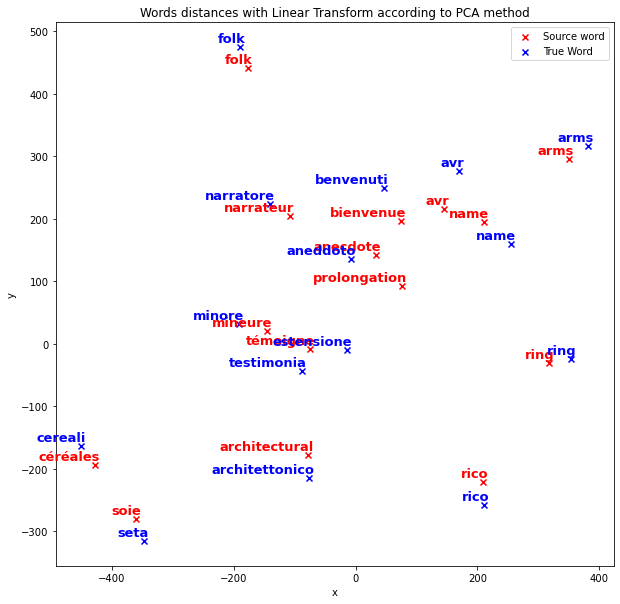

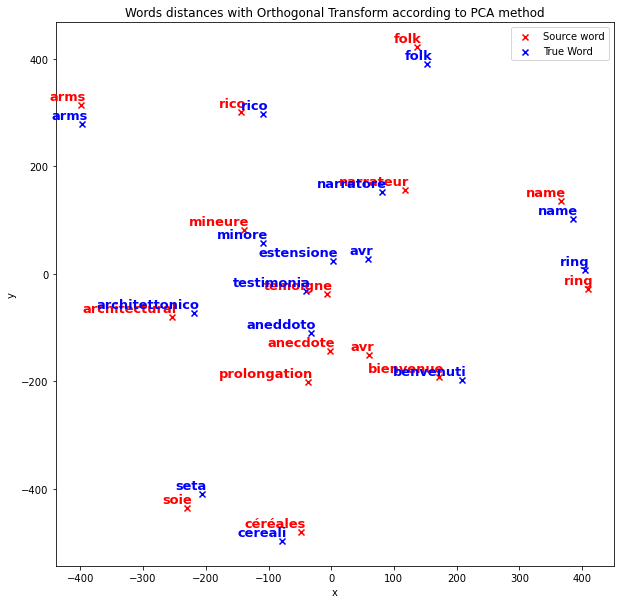

In [43]:
idx_to_plot = random.sample(range(0, len(fr_test_frit)), 15)
W = model_ols_frit.W
tsne_plot(idx_to_plot, fr_test_frit, it_test_frit, W, data_fr, data_it, bilingual_test_frit, "Linear Transform")

W = model_ortho_frit.W
tsne_plot(idx_to_plot, fr_test_frit, it_test_frit, W, data_fr, data_it, bilingual_test_frit, "Orthogonal Transform")

>> #### c - Comparison between Linear and Orthogonal Transform Italian French

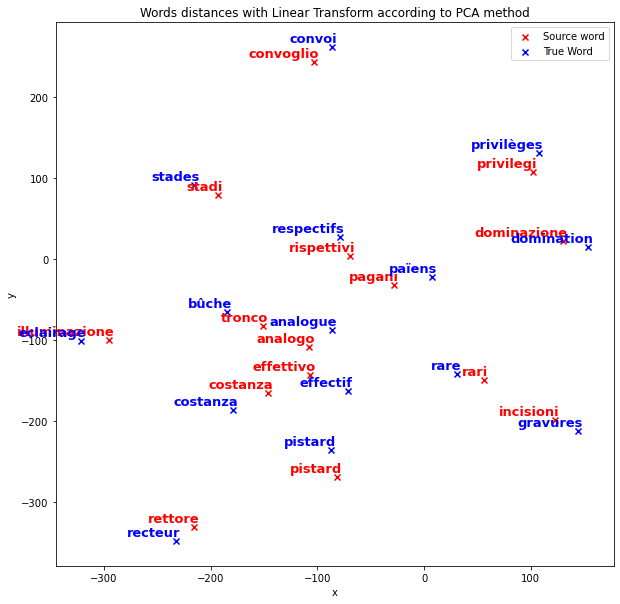

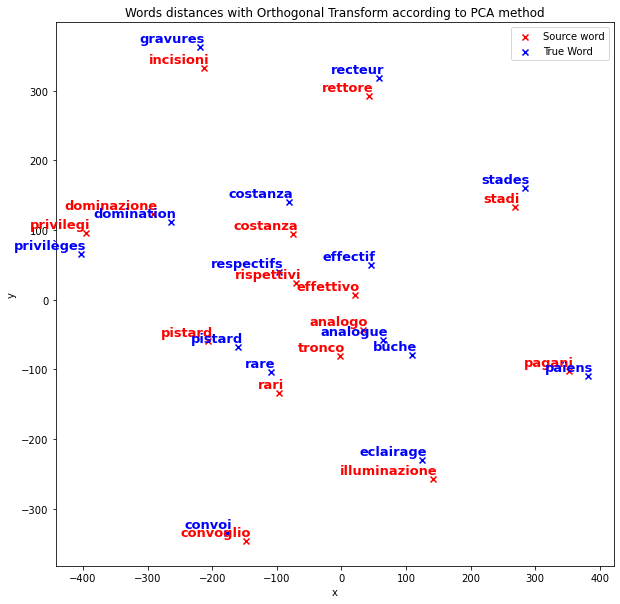

In [44]:
idx_to_plot = random.sample(range(0, len(it_test_itfr)), 15)
W = model_ols_itfr.W
tsne_plot(idx_to_plot, it_test_itfr, fr_test_itfr, W, data_it, data_fr, bilingual_test_itfr, "Linear Transform")

W = model_ortho_itfr.W
tsne_plot(idx_to_plot, it_test_itfr, fr_test_itfr, W, data_it, data_fr, bilingual_test_itfr, "Orthogonal Transform")

>> #### d - Comparison between Linear and Orthogonal Transform English Greek

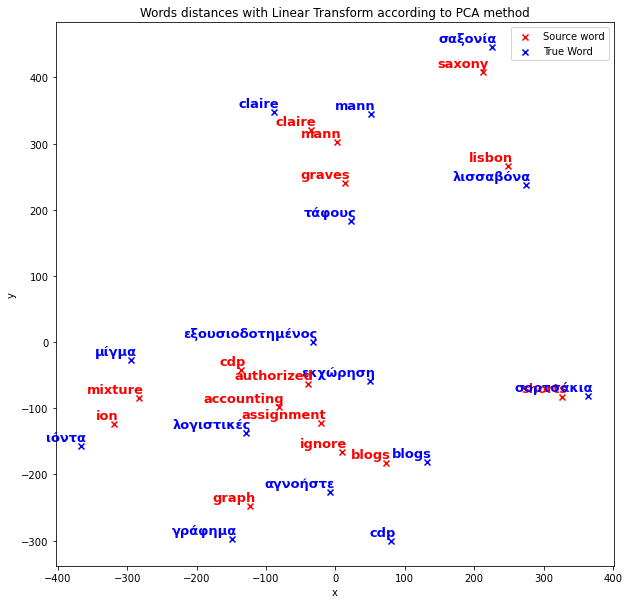

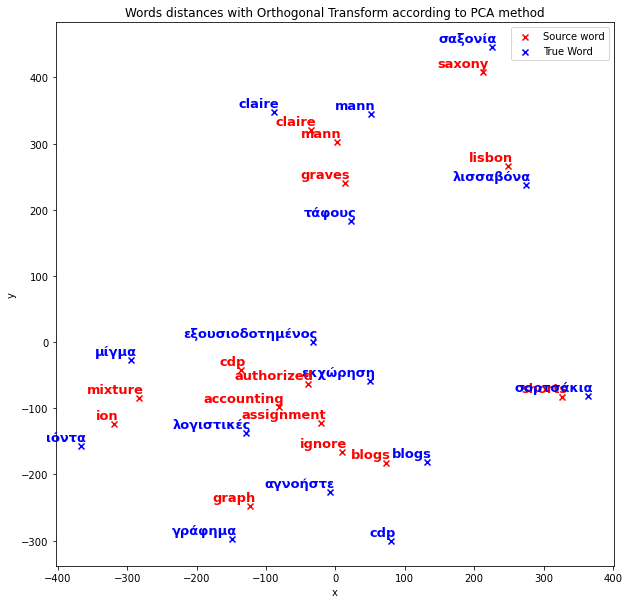

In [45]:
idx_to_plot = random.sample(range(0, len(en_test_enel)), 15)
W = model_ols_enel.W
tsne_plot(idx_to_plot, en_test_enel, el_test_enel, W, data_en, data_el, bilingual_test_enel, "Linear Transform")

W = model_ols_enel.W
tsne_plot(idx_to_plot, en_test_enel, el_test_enel, W, data_en, data_el, bilingual_test_enel, "Orthogonal Transform")

>> #### e - Comparison between Linear and Orthogonal Transform Greek English

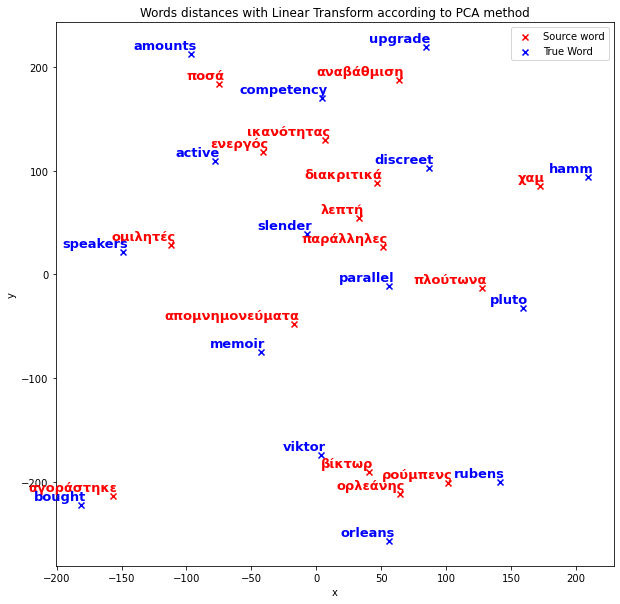

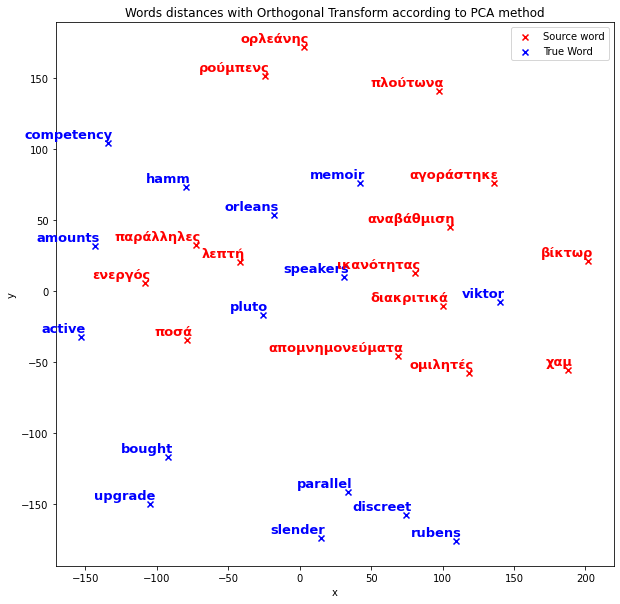

In [46]:
idx_to_plot = random.sample(range(0, len(el_test_elen)), 15)
W = model_ols_elen.W
tsne_plot(idx_to_plot, el_test_elen, en_test_elen, W, data_el, data_en, bilingual_test_elen, "Linear Transform")

W = model_ols_enel.W
tsne_plot(idx_to_plot, el_test_elen, en_test_elen, W, data_el, data_en, bilingual_test_elen, "Orthogonal Transform")

>> #### f - Comparison between Linear and Orthogonal Transform English Chinese

C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20919 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32173 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\ba

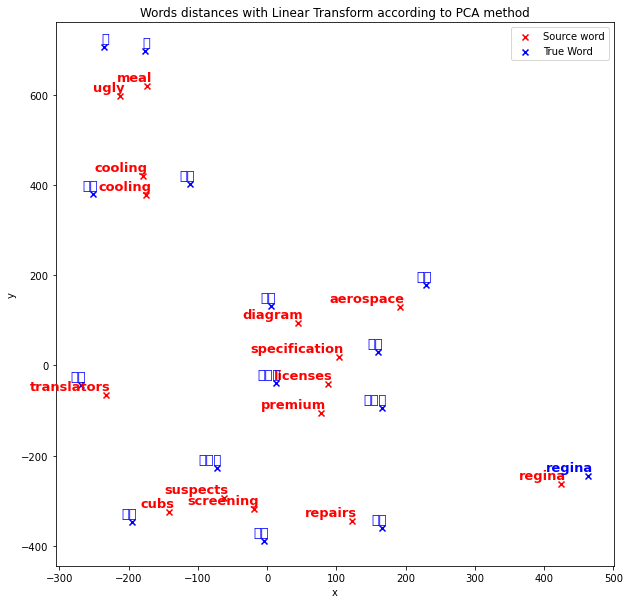

C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20919 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32173 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\ba

C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 30097 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29359 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Salome Papereux\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 39184 missing from current font.
  font.set_text(s, 0, flags=flags)


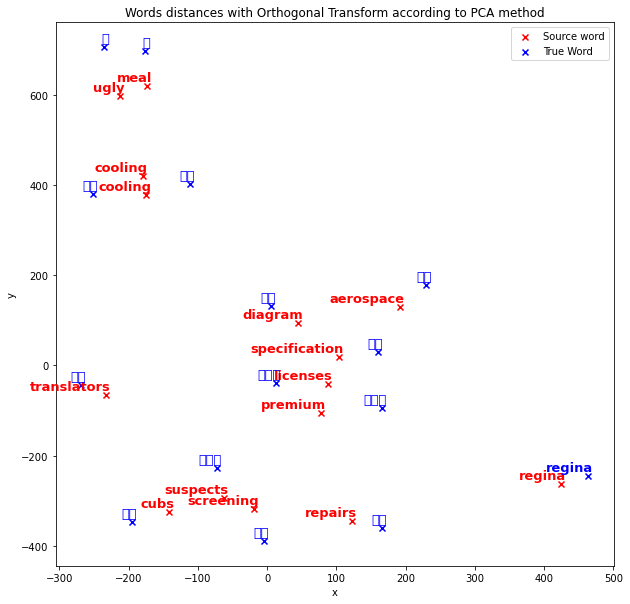

In [47]:
idx_to_plot = random.sample(range(0, len(el_test_elen)), 15)
W = model_ols_ench.W
tsne_plot(idx_to_plot, en_test_ench, ch_test_ench, W, data_en, data_ch, bilingual_test_ench, "Linear Transform")

W = model_ols_ench.W
tsne_plot(idx_to_plot, en_test_elen, ch_test_ench, W, data_en, data_ch, bilingual_test_ench, "Orthogonal Transform")

### All plots 

In [72]:
X = np.arange(1,8)
a = model_ols_fren.accuracies[0]
b = model_ortho_fren.accuracies[0]

c = model_ols_enfr.accuracies[0]
d = model_ortho_enfr.accuracies[0]

e = model_ols_frit.accuracies[0]
f = model_ortho_frit.accuracies[0]

g = model_ols_itfr.accuracies[0]
h = model_ortho_itfr.accuracies[0]

i = model_ols_enel.accuracies[0]
j = model_ortho_enel.accuracies[0]

k = model_ols_elen.accuracies[0]
l = model_ortho_elen.accuracies[0]

m = model_ols_ench.accuracies[0]
n = model_ortho_ench.accuracies[0]


x = ['FR-EN', 'EN-FR', 'FR-IT', 'IT-FR', 'EN-GR', 'GR-EN', 'EN-CH']
y = [a, b, c, d, e, f, g, h, i, j, k, l, m, n]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=x,
    y=[a, c, e, g, i, k, m],
    name='Othogonal Transformation',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=x,
    y=[b, d, f, h, j, l, n],
    name='Linear Transformation',
    marker_color='lightsalmon'
))

fig.update_layout(
    title="Accuracy according to languages and methods used",
    xaxis_title="Languages",
    yaxis_title="Accuracy",
    legend_title="Methods used",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
))

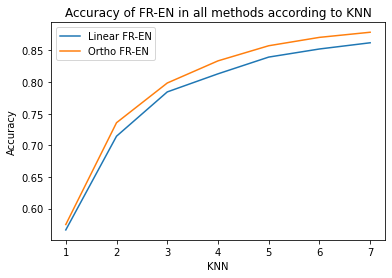

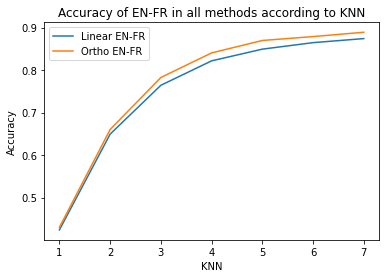

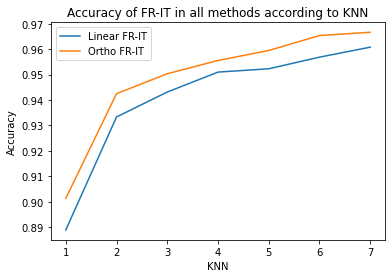

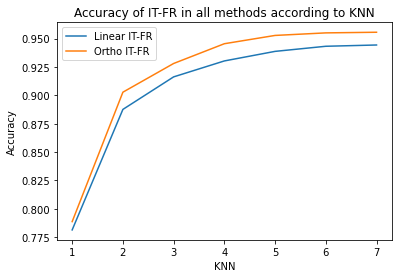

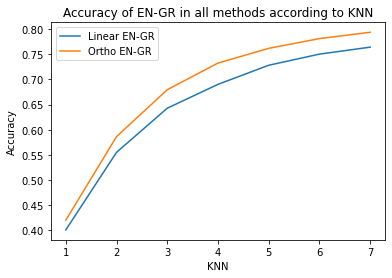

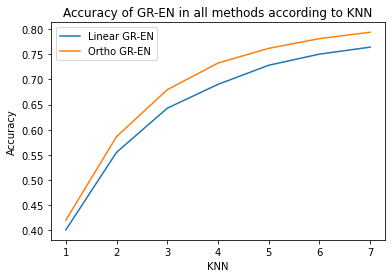

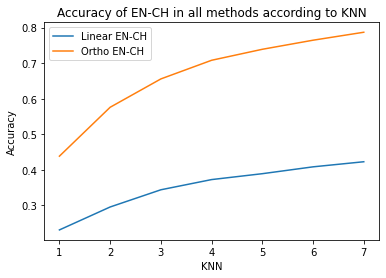

In [73]:
X = np.arange(1,8)
plt.plot(X, model_ols_fren.accuracies, label = "Linear FR-EN")
plt.plot(X, model_ortho_fren.accuracies, label = "Ortho FR-EN")
plt.title("Accuracy of FR-EN in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

plt.plot(X, model_ols_enfr.accuracies, label = "Linear EN-FR")
plt.plot(X, model_ortho_enfr.accuracies, label = "Ortho EN-FR")
plt.title("Accuracy of EN-FR in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

plt.plot(X, model_ols_frit.accuracies, label = "Linear FR-IT")
plt.plot(X, model_ortho_frit.accuracies, label = "Ortho FR-IT")
plt.title("Accuracy of FR-IT in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

plt.plot(X, model_ols_itfr.accuracies, label = "Linear IT-FR")
plt.plot(X, model_ortho_itfr.accuracies, label = "Ortho IT-FR")
plt.title("Accuracy of IT-FR in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

plt.plot(X, model_ols_enel.accuracies, label = "Linear EN-GR")
plt.plot(X, model_ortho_enel.accuracies, label = "Ortho EN-GR")
plt.title("Accuracy of EN-GR in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

plt.plot(X, model_ols_enel.accuracies, label = "Linear GR-EN")
plt.plot(X, model_ortho_enel.accuracies, label = "Ortho GR-EN")
plt.title("Accuracy of GR-EN in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

plt.plot(X, model_ols_ench.accuracies, label = "Linear EN-CH")
plt.plot(X, model_ortho_ench.accuracies, label = "Ortho EN-CH")
plt.title("Accuracy of EN-CH in all methods according to KNN")
plt.legend()
plt.xlabel("KNN")
plt.ylabel("Accuracy")
plt.show()

## II - UNSUPERVISED LEARNING

> ### 1) Generative Adversarial Networks - GAN

Secondly, we implemented the unsupervised approach. In this approach, we suppose that we don't know the pair of corresponding words from source embeddings to target embeddings. This method then relies on the adversarial training of two models, a generator (or mapping) and a discriminator. \\\\
                    Let $\mathcal{X} = \{x_1, ..., x_n\}$ and $\mathcal{Y} = \{y_1, ..., y_m\}$ be two sets of $n$ and $m$ word embeddings coming from a source and a target language respectively. The first model is then the mapping matrix $W$ that solves the following problem :
                    
\begin{equation}
\mathop{argmin}_{W \in M_d(\mathbb{R})} ||WX - Y||
\end{equation}
By adding an orthogonalization constraint on $W$, as in the supervised methods, we increase the accuracy. At each step, we therefore perform the following update to keep that constraint : 
\begin{equation}
W \leftarrow(1+\beta) W-\beta\left(W W^{T}\right) W
\end{equation}

A second model called a discriminator is then trained to learn to differentiate the origin of the embeddings it receives as input. The mapping is trained to fool the discriminator, which means that its goal is to make the discriminator output 1 for generated embeddings $WX$. 

The training then consists of an alternate stochastic gradient update of each model with their loss being opposed. As the discriminator becomes stronger, so does the mapping which outputs $WX$. All the generated embeddings become closer to belonging to the target latent space, and the similarities between languages embedding spaces make that they will fall close to the real translations according to cosine similarity.\\\\
                    We found our best results with a discriminator model of 3 hidden blocks of a fully connected layer of 2048, a dropout and a leaky ReLu activation, compared to two in the paper. We also changed the learning method for the mapping model by only propagating the loss on generated data, making the generator learn faster. This translates to propagating the following losses : 
\begin{equation}
\mathcal{L}_D(Discriminator|W) = - \frac{1} {n} \sum_{i=1}^{n} \log P(source = 0|Wx_i) - \frac{1} {m} \sum_{i=1}^{m} \log P(source = 1|y_i)
\end{equation}
\begin{equation}
\mathcal{L}_W(W|Discriminator) = - \frac{1} {n} \sum_{i=1}^{n} \log P(source = 1|Wx_i)
\end{equation}
                    
After enough iterations, we then use a Procrustes refinement method. This method relies on taking the embeddings that $W$ outputs and the target embeddings of the most frequent words, and looking at the closest pairs according to cosine similarity. We then reduce the distance between those words, to try to match perfectly the target embedding space. This is done using Procrustes Algorithm, which is relies on updated W iteratively using singular value decomposition.\\

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Generator(nn.Module):
    
    """
      This defines the model that takes as input an embedding from the source language X
      and outputs an embedding W @ X supposed to be close to the the target language (its translation)
      This model is a 300 x 300 matrice, represented by the linear layer W. 

      args : 
          - beta : beta parameter for orthogonalization of W
    """

    def __init__(self, beta = 0.01):
        super().__init__()
        self.W = nn.Linear(300, 300, bias=False)
        self.beta = beta

    def forward(self, x):
        return self.W(x)
    
    """
    Forcing an orthogonalize constraint on W improves the accuracy of the prediction
    """
    def orthogonalize(self):
        W = self.W.weight.data
        W_ortho = (1 + self.beta) * W - self.beta * W.mm(W.transpose(0,1).mm(W))
        self.W.weight.data = W.copy_(W_ortho)

    """
    Used for refinement. We use the surest predictions that W has made to recompute W using Procrustes solution on those predictions.
    This way, it closes together the surest predictions, and with them the other predictions to give better accuracy.  
    
    args :
        - target_embeddings : Y embeddings from the target language
        - predicted_embeddings : W @ X  with X embeddings from the source language
        - similar_pairs : pair of words (source, target) that W would pair together (according to cosine similarity)
    """
    def procrustes(self, predicted_embeddings, target_embeddings, similar_pairs):
        A = predicted_embeddings[similar_pairs[:,0]]
        B = target_embeddings[similar_pairs[:,1]]
        U, S, V_t = scipy.linalg.svd(B.T.dot(A), full_matrices=True)
        self.W.weight.data.copy_(torch.tensor(U.dot(V_t)).type_as(self.W.weight.data))


class Discriminator(nn.Module):
    """
      This defines the model that takes as input embeddings from the target language Y,
      or generated embeddings from the source language W @ X.
      This model uses frequent dropouts and 2 hidden layers of 2048 x 2048 to have better accuracy.
      It should output a single value after a sigmoid activation : 
        - 1 if the model thinks the embedding is from Y
        - 0 if the model thinks the embedding is from W @ X
    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(300, 2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x).reshape(-1)

In [27]:
class GAN():

    def __init__(self, src_path, tgt_path, test_path, epochs=40, batch_size=32, lr=0.1, decay=0.98, beta=0.01):
        """
        Defines the adversarial GAN and the methods to train and test it.
        
        args :
            - src_path       path to the .vec file with the embeddings of the source language
            - tgt_path       path to the .vec file with the embeddings of the target language
            - test_path      path to the .txt file with the set of translations of the test set
            - epochs         number of epochs to train on
            - batch_size     batch size to train on 
            - lr             learning rate to start off with 
            - decay          decay of the learning rate at each epoch 
            - beta           beta parameter to orthogonalize the generator at each step
        """

        ### LOADING THE DATA

        # We load a maximum amount of embeddings at first (200k) to ensure we will have all the embeddings of the test set 
        self.src_embeddings, self.src_id2word, self.src_word2id = self.load_vec(src_path)
        self.targ_embeddings, self.targ_id2word, self.targ_word2id = self.load_vec(tgt_path)
        
        self.epochs, self.batch_size = epochs, batch_size
        
        # We load the test set and store the embeddings in test_source_embeddings and test_target_embeddings (their indices are alined)
        self.df_test = pd.read_csv(test_path, sep=" ", header = None, na_filter=False, error_bad_lines=False)     # Sometimes the separator is '\t' 
        self.dico_test = {}
        self.test_source_embeddings, self.test_target_embeddings = [], []
        self.load_data()
        
        # We reduce the dataset to the first 50000 embeddings otherwise the training is too long
        self.src_embeddings, self.targ_embeddings = self.src_embeddings[:50000, :], self.targ_embeddings[:50000, :]


        ### MODEL DEFINITION
        self.generator = Generator(beta).to(device)
        self.discriminator = Discriminator().to(device)
        
        # Here we store the best generator according to accuracy on the test set, to select our best epoch
        self.best_W = None
        self.best_accuracy = 0

        # Optimisation parameters and learning rate decays for each model 
        self.BCE = nn.BCELoss()
        self.optim_discri = optim.SGD(self.discriminator.parameters(), lr=lr)
        self.optim_gen = optim.SGD(self.generator.parameters(), lr=lr)
        self.lr_decay_discri = StepLR(self.optim_discri, step_size=1, gamma=decay)
        self.lr_decay_gen = StepLR(self.optim_gen, step_size=1, gamma=decay)

        ### DATA
        self.X = TensorDataset(torch.from_numpy(self.src_embeddings).float().to(device))
        self.Y = TensorDataset(torch.from_numpy(self.targ_embeddings).float().to(device))

        self.dataloaderX = DataLoader(self.X, batch_size=batch_size, shuffle=True)
        self.dataloaderY = DataLoader(self.Y, batch_size=batch_size, shuffle=True)

        self.history = {"discriminator loss" : [], "generator loss" : [], "accuracy" : []}

    def discriminator_step(self, y):
        """
          Represents one fitting forward and backward step for the discriminator
        """
        # We compute the output of the discriminator on real vs fake data
        # On real data
        output_discriminator_real = self.discriminator(y)
        
        # On fake data generated with the generator
        x = next(iter(self.dataloaderX))
        x = x[0].float().to(device)
        fake_y = self.generator(x)
        output_discriminator_fake = self.discriminator(fake_y)
        
        # Total output of the discriminator
        output_discriminator = torch.cat((output_discriminator_real, output_discriminator_fake), dim=0)

        # The labels are 1 for the real data, 0 for the fake one, but we soften them for better results
        labels = torch.zeros(output_discriminator_real.shape[0] + output_discriminator_fake.shape[0]).to(device)
        labels[:output_discriminator_real.shape[0]] = 0.8
        labels[output_discriminator_real.shape[0]:] = 0.2

        # Propagation of the loss
        loss = self.BCE(output_discriminator, labels)
        self.optim_discri.zero_grad()
        loss.backward()
        self.optim_discri.step()
        self.history['discriminator loss'].append(loss.item())

    def generator_step(self):
        """
          Represents one fitting forward and backward step for the generator
        """

        # We compute the output of the discriminator on fake data generated with the generator (forward pass)
        x = next(iter(self.dataloaderX))
        x = x[0].float().to(device)
        fake_y = self.generator(x)
        output_discriminator_fake = self.discriminator(fake_y)

        # Expected labels should all be 1 since we want the discriminator to be fooled
        fake_labels = torch.zeros(fake_y.shape[0]).to(device)
        fake_labels[:] = 0.8

        # Propagation of the loss
        loss = self.BCE(output_discriminator_fake, fake_labels)
        self.optim_gen.zero_grad()
        loss.backward()
        self.optim_gen.step()
        self.history['generator loss'].append(loss.item())
        self.generator.orthogonalize()

    def fit(self):
        """
          Fitting loop on the desired number of epochs
        """
        
        print("Beginning fitting..")
        
        for epoch in range(self.epochs): 
            
            for _, y in enumerate(self.dataloaderY):
                # At each step, we train the discriminator to not be fooled, and then the generator to fool it
                self.discriminator_step(y[0].float().to(device))
                self.generator_step()
            
            accuracy = self.accuracy()
            
            # We store the best generator computed during the fitting
            if accuracy > self.best_accuracy : 
                self.best_W = self.generator.W.weight.data.cpu().numpy()
                self.best_accuracy = accuracy
                
            self.history["accuracy"].append(accuracy)
            print(f'Epoch {epoch+1}/{self.epochs} -> Discriminator loss : {self.history["discriminator loss"][-1]}, Generator Loss : {self.history["generator loss"][-1]}, Accuracy : {accuracy}')  
            self.lr_decay_discri.step()
            self.lr_decay_gen.step() 

        # We return the best generator computed during the fitting
        self.generator.W.weight.data.copy_(torch.tensor(self.best_W))
        print("Fitting Over")

    def refine(self):
        """
          Refinement loop on the computed W. While it increases the accuracy, the refinement keeps going
        """

        print("Beginning refinement..")
        self.generator.procrustes(self.src_embeddings, self.targ_embeddings, self.similar_pairs())
        accuracy = self.accuracy()
        i = 0
        while accuracy > self.best_accuracy :
            i+=1
            print(f'Refinement {i}')
            print(f'New accuracy : {accuracy}')
            self.best_accuracy = accuracy 
            self.best_W = self.generator.W.weight.data.cpu().numpy()
            self.generator.procrustes(self.src_embeddings, self.targ_embeddings, self.similar_pairs())
            accuracy = self.accuracy()

        self.generator.W.weight.data.copy_(torch.tensor(self.best_W))
        print('Refinement over')

    def load_vec(self, emb_path, nmax=200000):
        """
          Loading function for the .vec files
          
          args : 
              - emb_path  path to the .vec file with the embeddings
              - nmax      number of embeddings to load
        """

        vectors = []
        word2id = {}
        with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
            next(f)
            for i, line in enumerate(f):
                word, vect = line.rstrip().split(' ', 1)
                vect = np.fromstring(vect, sep=' ')
                assert word not in word2id, 'word found twice'
                vectors.append(vect)
                word2id[word] = len(word2id)
                if len(word2id) == nmax:
                    break
        id2word = {v: k for k, v in word2id.items()}
        embeddings = np.vstack(vectors)
        return embeddings, id2word, word2id

    def plot_loss(self):
        """
          Plot the history of the losses during the training
        """

        plt.plot(self.history["generator loss"], label="Generator Loss")
        plt.plot(self.history["discriminator loss"], label="Discriminator Loss")
        plt.title("Loss of generator and discriminator according to Time")
        plt.xlabel('Iteration')
        plt.ylabel('BCE Loss')
        plt.legend()
    
    def plot_accuracy(self):
        """
          Plot the history of the accuracy during the training
        """

        plt.plot(self.history["accuracy"], label="Accuracy")
        plt.title("Nearest Neighbors Accuracy on Test Set according to Time")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    def load_data(self):
        """
          Loads the self.dico_test, dict between the source words and the target words
          Sometimes one word has multiple meaning and so translations
          Also loads the embeddings that correspond to those words, in order
        """

        for _, (w1, w2) in self.df_test.iterrows(): 
            if w1 in self.dico_test.keys():
                self.dico_test[w1].append(w2)
            else:
                self.dico_test[w1] = [w2]
                
        for w in self.df_test[0] :
            if w in self.src_word2id.keys() :
                self.test_source_embeddings.append(self.src_embeddings[self.src_word2id[w]])

        for w in self.df_test[1] :
            if w in self.targ_word2id.keys() :
                self.test_target_embeddings.append(self.targ_embeddings[self.targ_word2id[w]])

    def predict(self):
        """
          Predicts the translation of the test source words based on closest embeddings according to cosine similarity
        """

        prediction = []
        predicted_embeddings = self.generator(torch.Tensor(self.test_source_embeddings).to(device)).detach().cpu().numpy()
        score = cosine_similarity(predicted_embeddings, self.targ_embeddings)
        closest_idx = score.argmax(axis=1)
        for i in closest_idx:
            prediction.append(self.targ_id2word[i])
        return prediction

    def accuracy(self):
        """
          Computes the 1 nearest neighbours accuracy based on the translation of the test source words with the current W
        """

        predictions = self.predict()
        good_predictions = 0
        for i in range(len(predictions)) :
            if predictions[i] in self.dico_test[self.df_test[0][i]]:
                good_predictions +=1
        return round(good_predictions / len(predictions) * 100, 2)    

    def similar_pairs(self, n=10000):
        """
          Computes cosine-similar pairs of embeddings from the W @ X and Y sets. 
          The similarity is computed from source to target embeddings, and from target to source embeddings.
          The pair that are closest in both ways are kept and returned
          Used for the procrustes refinement after the fitting
        """

        predicted_embeddings = self.generator(torch.Tensor(self.src_embeddings).to(device)).detach().cpu().numpy()
        
        scores_src_to_tgt = cosine_similarity(predicted_embeddings, self.targ_embeddings[:n])
        closest_idx_st = scores_src_to_tgt.argmax(axis=1)
        similar_pairs_src_to_tgt = {(a, b) for a, b in enumerate(closest_idx_st)}
        
        scores_tgt_to_src = cosine_similarity(self.targ_embeddings[:n], predicted_embeddings)
        closest_idx_ts = scores_tgt_to_src.argmax(axis=1)
        similar_pairs_tgt_to_src = {(b, a) for a, b in enumerate(closest_idx_ts)}
            
        similar_pairs = list(similar_pairs_src_to_tgt.intersection(similar_pairs_tgt_to_src))
        similar_pairs.sort()
        return np.array(similar_pairs)


### Gan training 

In [16]:
#FRENCH - ENGLISH
"""src_path = 'wiki.fr.vec'
tgt_path = 'wiki.en.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.5000-6500.txt'"""

#ENGLISH - FRENCH
src_path = 'wiki.en.vec'
tgt_path = 'wiki.fr.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.5000-6500.txt'

#FRENCH - ITALIAN
"""src_path = 'wiki.fr.vec'
tgt_path = 'wiki.it.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-it.5000-6500.txt'"""

#ITALIAN - FRENCH
"""src_path = 'wiki.it.vec'
tgt_path = 'wiki.fr.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/it-fr.5000-6500.txt'"""

#ENGLISH - GREEK
"""src_path = 'wiki.en.vec'
tgt_path = 'wiki.el.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/en-el.5000-6500.txt'"""

#GREEK-ENGLISH
"""src_path = 'wiki.el.vec'
tgt_path = 'wiki.en.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/el-en.5000-6500.txt'"""

#ENGLISH - CHINESE 
"""src_path = 'wiki.en.vec'
tgt_path = 'wiki.zh.vec'
test_path = 'https://dl.fbaipublicfiles.com/arrival/dictionaries/en-zh.5000-6500.txt'"""

model_GAN = GAN(src_path, tgt_path, test_path)
model_GAN.fit()

Beginning fitting..
Epoch 1/40 -> Discriminator loss : 0.6047642230987549, Generator Loss : 1.0097360610961914, Accuracy : 0.0
Epoch 2/40 -> Discriminator loss : 0.5907635688781738, Generator Loss : 1.1524603366851807, Accuracy : 0.0
Epoch 3/40 -> Discriminator loss : 0.5855974555015564, Generator Loss : 1.2735357284545898, Accuracy : 0.07
Epoch 4/40 -> Discriminator loss : 0.593219518661499, Generator Loss : 1.3567118644714355, Accuracy : 0.61
Epoch 5/40 -> Discriminator loss : 0.5684062242507935, Generator Loss : 1.1297801733016968, Accuracy : 1.43
Epoch 6/40 -> Discriminator loss : 0.5704773664474487, Generator Loss : 1.3274240493774414, Accuracy : 4.62
Epoch 7/40 -> Discriminator loss : 0.6174372434616089, Generator Loss : 1.3871405124664307, Accuracy : 12.3
Epoch 8/40 -> Discriminator loss : 0.6042575836181641, Generator Loss : 1.4173927307128906, Accuracy : 19.54
Epoch 9/40 -> Discriminator loss : 0.5831754803657532, Generator Loss : 1.0047483444213867, Accuracy : 30.78
Epoch 10/

#### Loss ploting 

Here, epochs is actually iterations

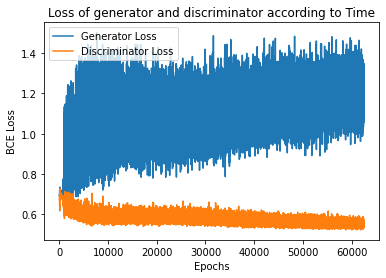

In [18]:
model_GAN.plot_loss()

#### Accuracy ploting 

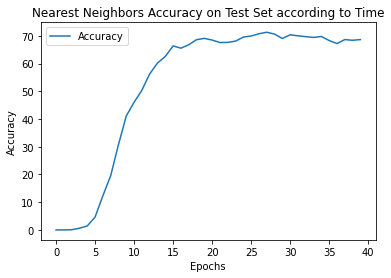

In [19]:
model_GAN.plot_accuracy()

In [20]:
model_GAN.accuracy()

71.29

#### Accuracy with the GAN and refinement

In [21]:
model_GAN.refine()

Beginning refinement..
Refinement 1
New accuracy : 79.34
Refinement 2
New accuracy : 79.48
Refinement 3
New accuracy : 79.95
Refinement over


#### Plots of words

In [23]:
def plot_similar_word(idx, model):

    Y = []
    word_labels = []
    for i in idx:
        Y.append(model.test_source_embeddings[i] @ model.best_W)
        word_labels.append(model.df_test[0][i])
    for i in idx:
        Y.append(model.test_target_embeddings[i])
        word_labels.append(model.df_test[1][i])
    print(len(Y))
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', n_iter=2500, random_state=23)
    Y = tsne_model.fit_transform(Y)

    # find tsne coords for 2 dimensions
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(idx) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

8


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


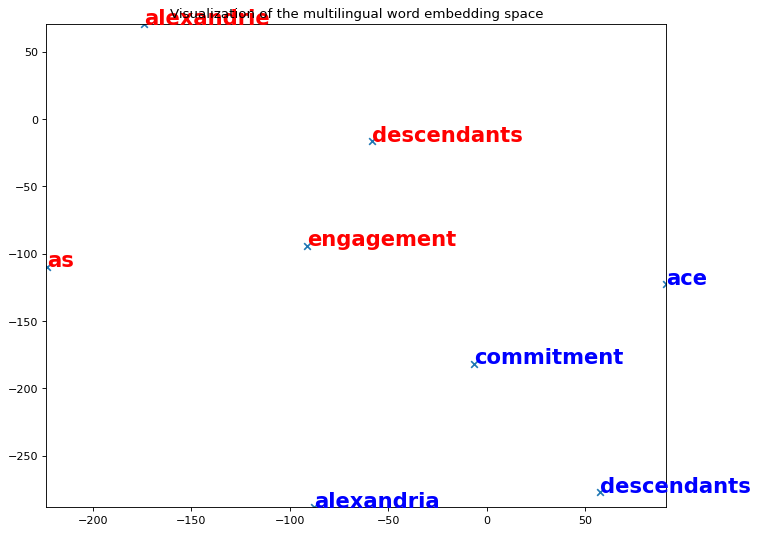

In [24]:
import random
idx = random.sample(range(1,len(model_GAN.test_target_embeddings)), 4)
plot_similar_word(idx, model_GAN)